In [1]:
import torch
import matplotlib.pyplot as plt

from bmadx.plot import plot_projections

from initial_beam import create_ground_truth_beam
from training import generate_images, train_model

In [2]:
gt_beam = create_ground_truth_beam()

ground truth distribution saved at data/gt_dist.pt


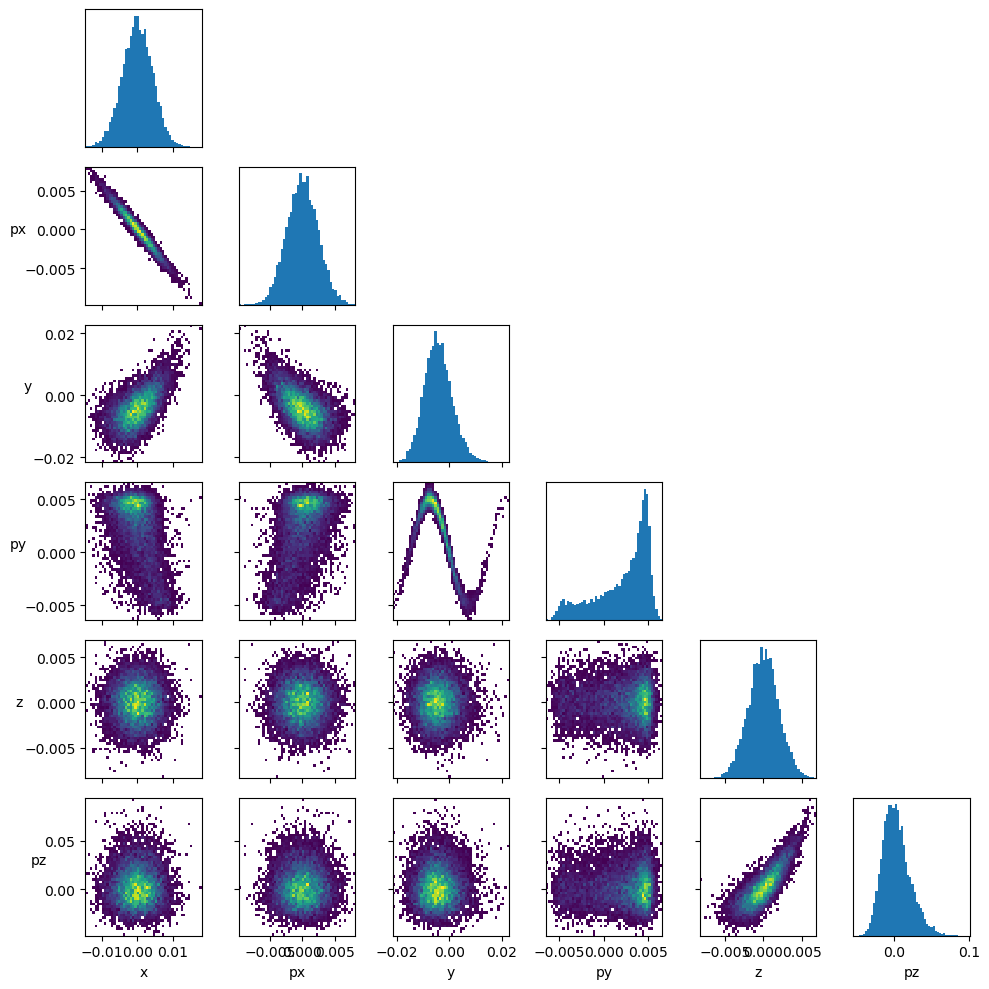

In [3]:
# plot projections
plot_projections(gt_beam.data.numpy(),
                 labels=['x', 'px', 'y', 'py', 'z', 'pz'],
                 bins=50,
                 background=False)

number of images = 20

image 0
k = tensor([-25.]) 1/m
stdx = 167.28250122070312 mm


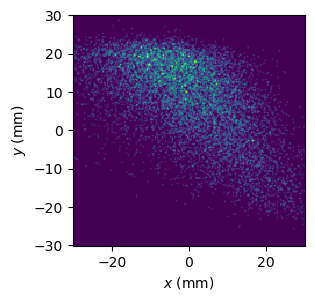

image 1
k = tensor([-22.8947]) 1/m
stdx = 142.8126983642578 mm


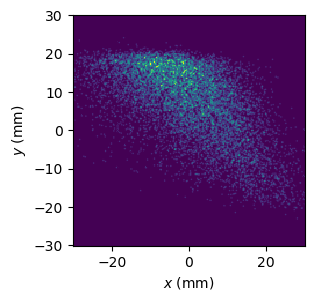

image 2
k = tensor([-20.7895]) 1/m
stdx = 120.42608642578125 mm


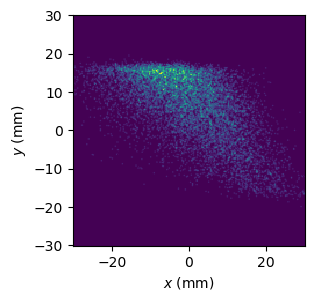

image 3
k = tensor([-18.6842]) 1/m
stdx = 100.0828857421875 mm


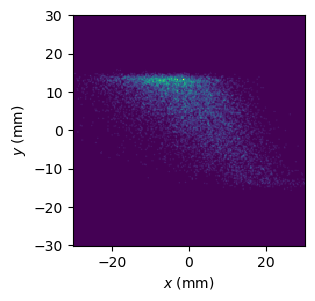

image 4
k = tensor([-16.5789]) 1/m
stdx = 81.74394226074219 mm


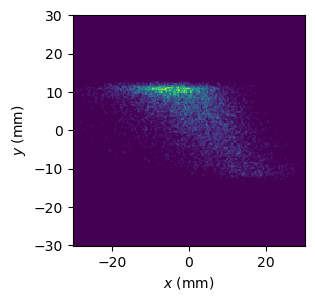

image 5
k = tensor([-14.4737]) 1/m
stdx = 65.37055969238281 mm


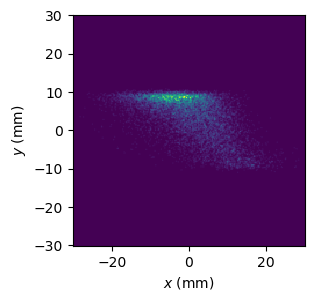

image 6
k = tensor([-12.3684]) 1/m
stdx = 50.924560546875 mm


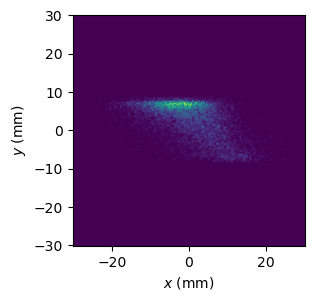

image 7
k = tensor([-10.2632]) 1/m
stdx = 38.36830520629883 mm


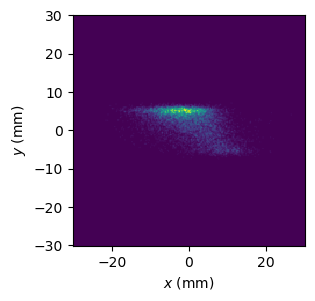

image 8
k = tensor([-8.1579]) 1/m
stdx = 27.664661407470703 mm


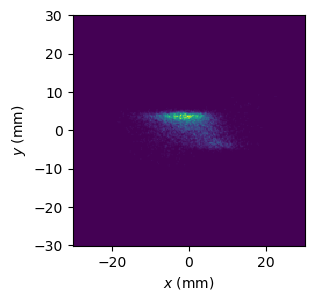

image 9
k = tensor([-6.0526]) 1/m
stdx = 18.77698516845703 mm


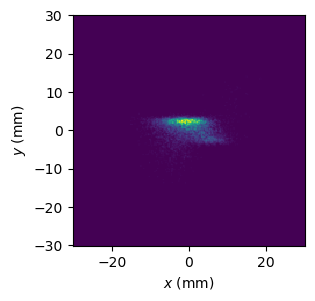

image 10
k = tensor([-3.9474]) 1/m
stdx = 11.669139862060547 mm


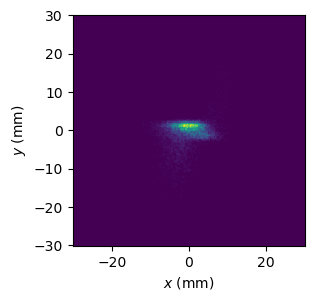

image 11
k = tensor([-1.8421]) 1/m
stdx = 6.305475234985352 mm


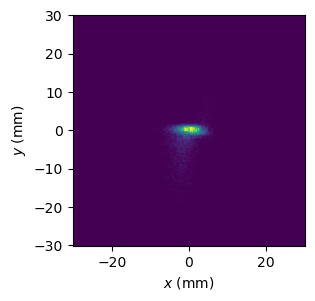

image 12
k = tensor([0.2632]) 1/m
stdx = 2.6508240699768066 mm


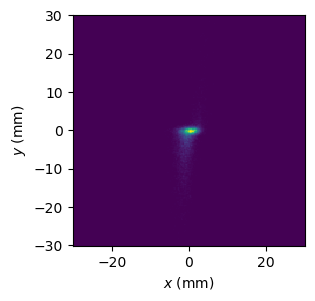

image 13
k = tensor([2.3684]) 1/m
stdx = 0.6704981923103333 mm


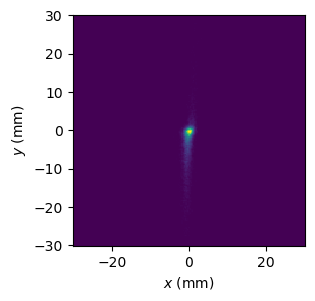

image 14
k = tensor([4.4737]) 1/m
stdx = 0.33028170466423035 mm


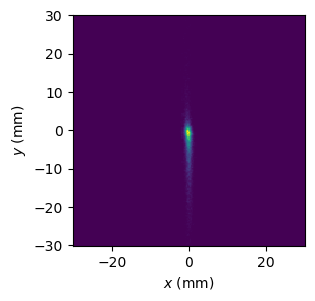

image 15
k = tensor([6.5789]) 1/m
stdx = 1.5964230298995972 mm


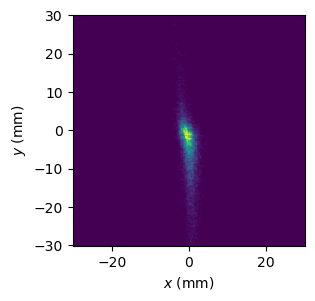

image 16
k = tensor([8.6842]) 1/m
stdx = 4.435631275177002 mm


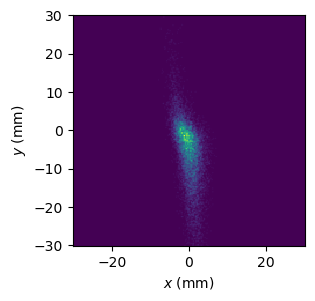

image 17
k = tensor([10.7895]) 1/m
stdx = 8.815074920654297 mm


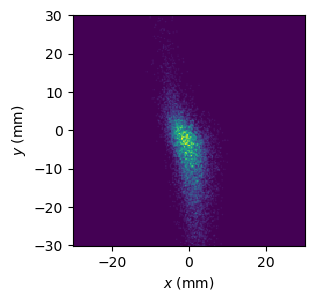

image 18
k = tensor([12.8947]) 1/m
stdx = 14.702362060546875 mm


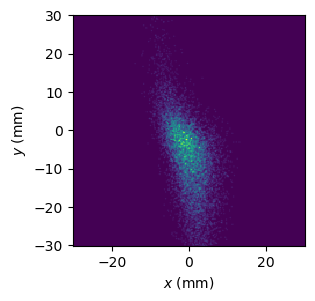

image 19
k = tensor([15.]) 1/m
stdx = 22.0655517578125 mm


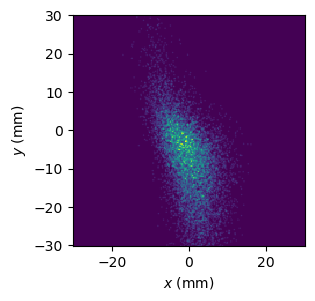

In [4]:
# generate training images
scan_data = generate_images(gt_beam, verbose=True)

In [5]:
# reconstruction
reconstructed_beam, pred_image_data = train_model()

Using device: cpu


/Users/jpga/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4311011., grad_fn=<MulBackward0>)


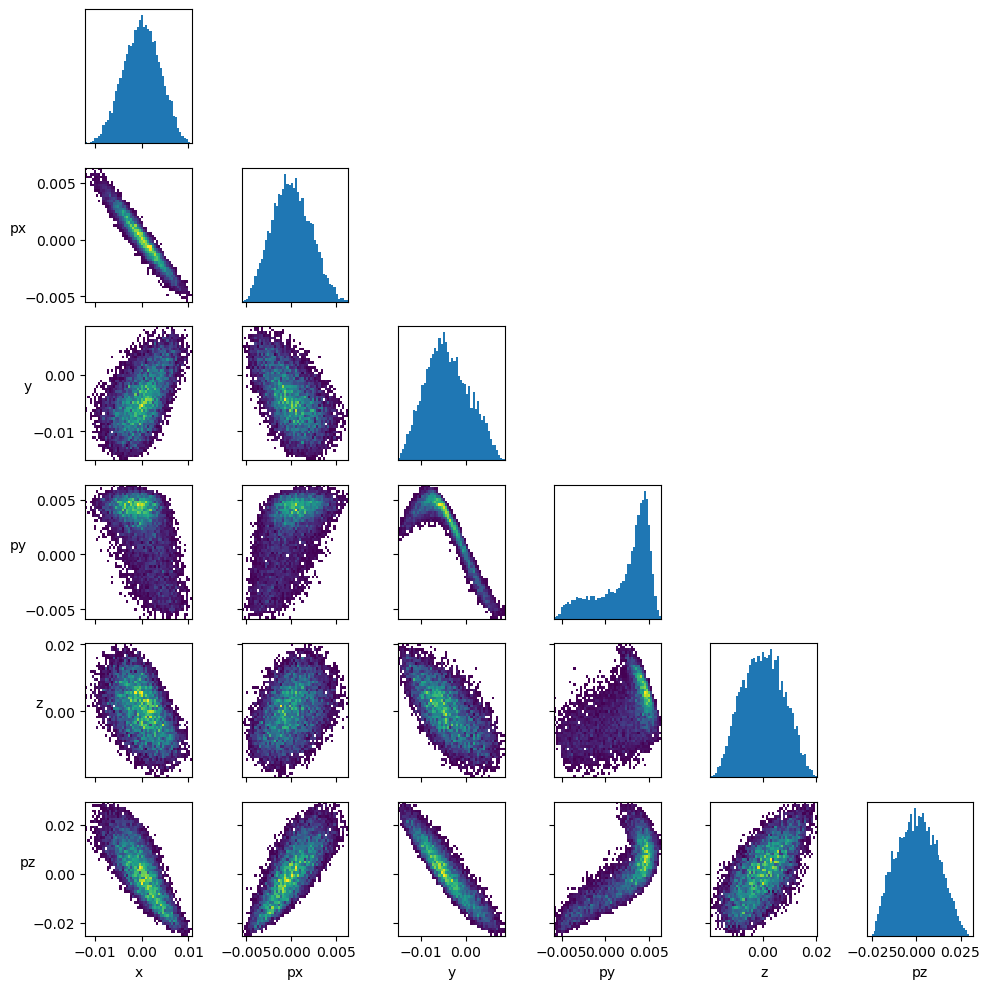

In [6]:
# reconstructed beam: 
plot_projections(reconstructed_beam.data.detach().cpu().numpy(),
                 labels=['x', 'px', 'y', 'py', 'z', 'pz'],
                 bins=50,
                 background=False)

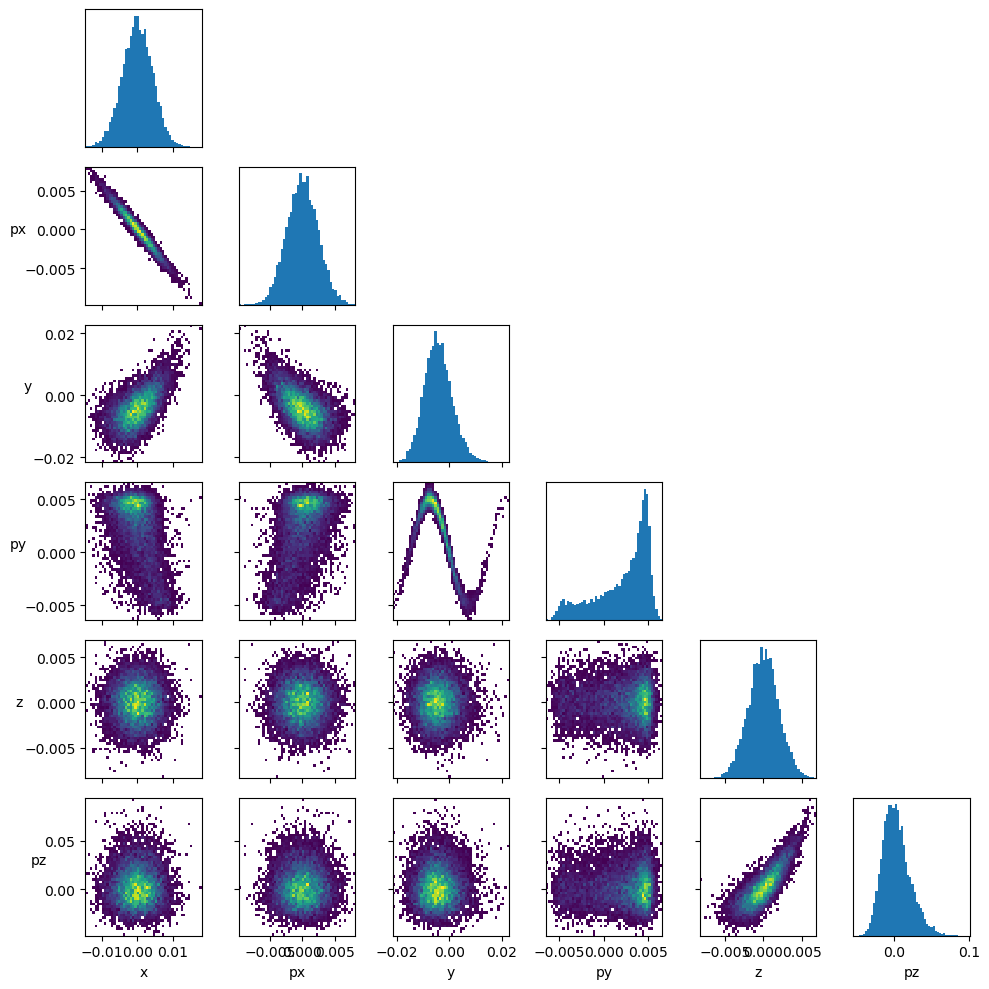

In [7]:
# ground truth beam:
plot_projections(gt_beam.data.numpy(),
                 labels=['x', 'px', 'y', 'py', 'z', 'pz'],
                 bins=50,
                 background=False)

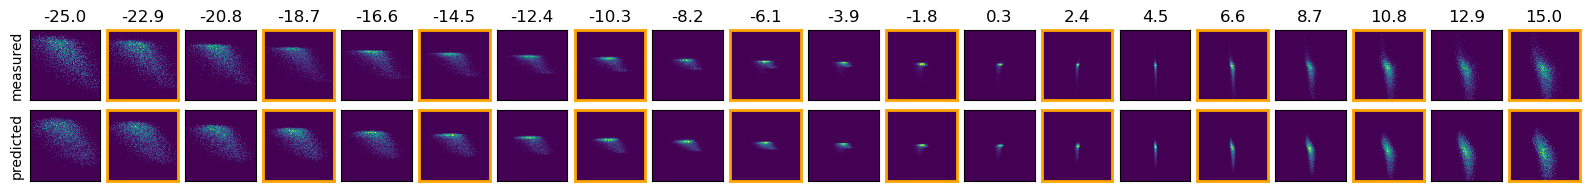

In [90]:
import numpy as np
def compare_screens(measured_images,
                    predicted_images,
                    bins,
                    quad_strengths=None,
                    test_ids=None
                    ):

    xx = np.meshgrid(bins, bins, indexing='ij')

    fig, ax = plt.subplots(2,20, figsize=(20,2))

    for i in range(len(measured_images)):
        ax[0, i].imshow(measured_images[i].T, origin='lower', interpolation='none')
        ax[1, i].imshow(predicted_images[i].T, origin='lower', interpolation='none')

        ax[0,i].tick_params(bottom=False, left=False,
                            labelbottom=False, labelleft=False)
        ax[1,i].tick_params(bottom=False, left=False,
                            labelbottom=False, labelleft=False)
        
        ax[0,0].set_ylabel('measured')
        ax[1,0].set_ylabel('predicted')
        
        if quad_strengths is not None:
            ax[0,i].set_title(f'{quad_strengths[i][0]:.1f}')

        if test_ids is not None:
            if i in test_ids:
                for spine in ax[0,i].spines.values():
                    spine.set_edgecolor('orange')
                    spine.set_linewidth(2)
                for spine in ax[1,i].spines.values():
                    spine.set_edgecolor('orange')
                    spine.set_linewidth(2)

    plt.subplots_adjust(wspace=0.1,
                        hspace=0.1)
    
    plt.show()

measured_images = scan_data['images']

predicted_images = pred_image_data['images']
quad_strengths = pred_image_data['quad_strengths']
bins = scan_data['bins']
test_ids = pred_image_data['test_ids']


compare_screens(measured_images, predicted_images, bins, quad_strengths, test_ids)

In [ ]:
# For testing purposes:

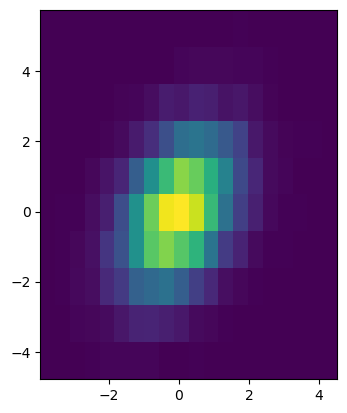

In [86]:
fig, ax = plt.subplots()
x = np.random.multivariate_normal([0,0], [[1,0.5],[0.5,2]], 10000)
image, xx, yy, _ = ax.hist2d(x[:,0],x[:,1], bins=[20,10])
ax.set_aspect('equal')


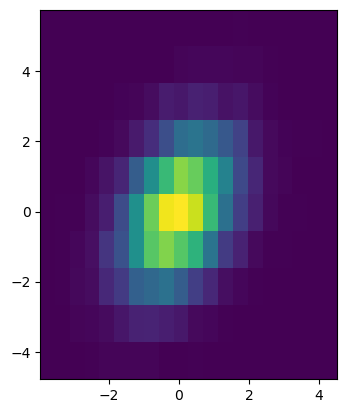

In [89]:
plt.imshow(image.T, origin='lower', extent=[xx[0], xx[-1],yy[0], yy[-1]], interpolation='none')